In [69]:
import math
from matplotlib import pyplot as plt

In [222]:
SINK_RADIX_BITS = 1
SINK_ABANDON_THRESHOLD = 100_000
NUM_PARTITIONS = 1 << SINK_RADIX_BITS

THREADS = 4
PARTITION_SQUASH_THRESHOLD = 50_000

In [223]:
max_time = 1_000
total_remaining = 10_000_000_000
squash_factor = 0.75

partitions = [{'count': 0, 'locked': False} for _ in range(NUM_PARTITIONS)]
thread_infos = [{'partition': -1, 'remaining': 0} for _ in range(THREADS)]

def do_squash(thread_info, effort_remaining):
    partition_idx = thread_info['partition']
    if partition_idx == -1 or effort_remaining == 0:
        return effort_remaining
    
    partition_remaining = thread_info['remaining']
    if partition_remaining == 0:
        assert(partition_idx == -1)
        return effort_remaining
    
    # Should have a valid partition idx, and the partition should be locked
    assert(partition_idx != -1)
    assert(partitions[partition_idx]['locked'] == True)

    squash_effort = min(partition_remaining, effort_remaining)
    thread_info['remaining'] -= squash_effort
    if thread_info['remaining'] == 0:
        thread_info['partition'] = -1
        partitions[partition_idx]['locked'] = False
    
    return effort_remaining - squash_effort


def done():
    if total_remaining != 0:
        return False
    
    for thread_info in thread_infos:
        if thread_info['remaining'] != 0:
            return False
    
    for partition in partitions:
        if partition['count'] >= PARTITION_SQUASH_THRESHOLD:
            return False
    
    return True

avg_squashes = []
for u in range(max_time):
    sum_to_squash = 0
    for partition in partitions:
        sum_to_squash += partition['count']
    for thread_info in thread_infos:
        sum_to_squash += thread_info['remaining']
    avg_squashes.append(sum_to_squash / NUM_PARTITIONS)
    
    if done():
        print('done')
        break   
    
    for thread_idx, thread_info in enumerate(thread_infos):
        effort_remaining = do_squash(thread_info, SINK_ABANDON_THRESHOLD)
        if effort_remaining == 0:
            continue
            
        effort_remaining = min(effort_remaining, total_remaining)
        
        # Should be done with squashing by now
        assert(thread_info['partition'] == -1)
        assert(thread_info['remaining'] == 0)
        
        # Now, do the regular work
        effort_per_partition = math.ceil(effort_remaining / NUM_PARTITIONS)
        for partition_idx, partition in enumerate(partitions):
            effort_this_partition = min(effort_remaining, effort_per_partition)
            effort_remaining -= effort_this_partition
            total_remaining -= effort_this_partition
            partition['count'] += effort_this_partition
            
            if partition['count'] < PARTITION_SQUASH_THRESHOLD:
                continue
            
            if partition['locked'] == True:
                continue
                
            if thread_info['partition'] != -1:
                continue
            
            thread_info['partition'] = partition_idx
            thread_info['remaining'] = partition['count']
            partition['count'] = 0
            partition['locked'] = True
#             # Now squash
#             effort_remaining = do_squash(thread_info, effort_remaining)
            
#             if effort_remaining == 0:
#                 break

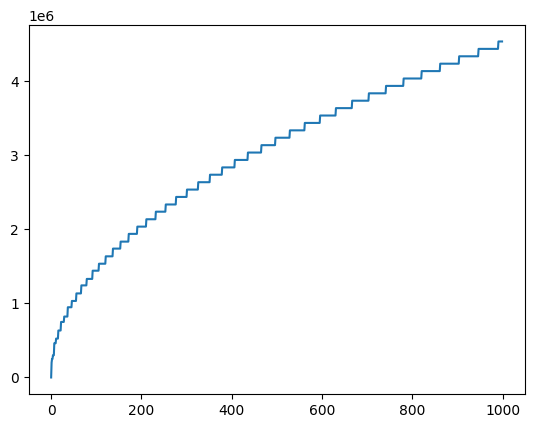

In [224]:
plt.plot(list(range(len(avg_squashes))), avg_squashes)
plt.show()

In [213]:
75*256*100000 / 1_000_000_000

1.92